In [1]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
import glob
from scipy.signal import butter
import scipy
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
from scipy import stats
import os
from scipy.sparse import spdiags
from ecgdetectors import Detectors
from tompkins_peak import QRSDetectorOffline
FS = 60
# ecg_detectors = Detectors(FS)


## FFT Heart Rate

In [2]:
def next_power_of_2(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

def calculate_fft_hr(ppg_signal, fs=60):
    ppg_signal = np.expand_dims(ppg_signal, 0)
    N = next_power_of_2(ppg_signal.shape[1])
    f_ppg, pxx_ppg = scipy.signal.periodogram(ppg_signal, fs=fs, nfft=N, detrend=False)
    fmask_ppg = np.argwhere((f_ppg >= 0.75) & (f_ppg <= 2.5))
    mask_ppg = np.take(f_ppg, fmask_ppg)
    mask_pxx = np.take(pxx_ppg, fmask_ppg)
    fft_hr = np.take(mask_ppg, np.argmax(mask_pxx, 0))[0] * 60
    return fft_hr, mask_ppg, mask_pxx


### Detrend signal

In [3]:
def detrend(signal, Lambda):
    signal_length = signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    # second-order difference matrix
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index, (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot((H - np.linalg.inv(H + (Lambda ** 2) * np.dot(D.T, D))), signal)
    return filtered_signal


### Read mat files

In [4]:
all_mat_path = sorted(glob.glob("./ProcessedDataNoVideo/*.mat"))

### Remove artifacts

In [5]:
def remove_artifact(ppg):
    ppgmean = np.mean(ppg)
    ppgstddev = np.std(ppg[:200])
    f1 = np.where(ppg < ppgmean + 4 *ppgstddev)[0]
    f2 = np.where(ppg > ppgmean - 4 *ppgstddev)[0]
    f = np.intersect1d(f1, f2)
    return np.take(ppg, f)

# def remove_artifact(ppg):
#     ppgmean = np.mean(ppg)
#     ppgstddev = np.std(ppg[:200])
#     f1 = np.where(ppg > ppgmean + 3 * ppgstddev)[0]
#     f2 = np.where(ppg < ppgmean - 3 * ppgstddev)[0]
#     f = np.union1d(f1, f2)
#     filtered_ppg = np.put(ppg, f, np.array([ppgmean]*f.shape[0]))
    
#     return np.take(ppg, f)

### Filter

In [6]:
def filter_ppg(ppg, fs=60, lpf=0.4, hpf=2.5):    
#     nyquistf = 1 / 2 * fs
#     [b_pulse, a_pulse] = butter(3, [lpf / nyquistf, hpf/nyquistf], btype='bandpass')
    [b_pulse, a_pulse] = butter(1, [lpf / fs * 2, hpf / fs * 2], btype='bandpass')
    return scipy.signal.filtfilt(b_pulse, a_pulse, np.double(ppg))

## Normalization

In [7]:
def normalize_ppg(ppg):
    ppg = ppg - np.min(ppg)
    ppg = ppg / np.max(ppg)
    return ppg

### Find peaks

In [8]:
def find_peaks(ppg, height=0.6):
    peaks, _ = scipy.signal.find_peaks(ppg, height=height, distance=20)
    return peaks

### Remove ectopic beats

In [9]:
def remove_ectopic(ppg_peaks):
    rr_intervals_list = np.diff(ppg_peaks)
    # # This remove ectopic beats from signal
    nn_intervals_list = remove_ectopic_beats(rr_intervals=rr_intervals_list, method="malik")
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
    return np.cumsum(interpolated_nn_intervals).astype(np.int)

## Plot func

In [10]:
def plot_peaks(test_face_ppg, test_ppg, test_ecg, peaks_face_ppg, peaks_ppg, peaks_ecg):
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(test_face_ppg)
    plt.plot(peaks_face_ppg, test_face_ppg[peaks_face_ppg], "x")
    plt.title('Face')
    plt.show()

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(test_ppg)
    plt.plot(peaks_ppg, test_ppg[peaks_ppg], "x")
    plt.title('Finger')
    plt.show()

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(test_ecg)
    plt.plot(peaks_ecg, test_ecg[peaks_ecg], "x")
    plt.title('ECG')
    plt.show()

def plot_signal(test_face_ppg, test_ppg, test_ecg, finger_hr_fft, face_hr_fft, ecg_hr_fft, ecg_peaks):
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(test_face_ppg)
    plt.title('Face: ' + str(face_hr_fft))
    plt.show()

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(test_ppg)
    plt.title('Finger: ' + str(finger_hr_fft))
    plt.show()

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(test_ecg)
    plt.plot(ecg_peaks, test_ecg[ecg_peaks], "x")
    plt.title('ECG: ' + str(ecg_hr_fft))
    plt.show()

def plot_fft(mask_ppg, mask_pxx, title):
    plt.plot(mask_ppg, np.reshape(mask_pxx, [-1, 1]))
    plt.title(f'{title} FFT')
    plt.show()


### Test

In [11]:
# all_mat_path = sorted(glob.glob("./ProcessedDataNoVideo/*.mat"))
# mat = scipy.io.loadmat(all_mat_path[12])
# test_face_ppg = mat['ppg_face'][0]
# test_ppg = 1 - mat['ppg'][0]
# test_ppg = detrend(test_ppg, 100)
# test_ecg = mat['ekg'][0]
# cutoff = 3000
# test_face_ppg = normalize_ppg(filter_ppg(remove_artifact(test_face_ppg)))[:cutoff]
# test_ppg = normalize_ppg(filter_ppg(remove_artifact(test_ppg)))[:cutoff]
# test_ecg = normalize_ppg(test_ecg[:cutoff])
# peaks_face_ppg = find_peaks(test_face_ppg)
# peaks_ppg = find_peaks(test_ppg)
# # peaks_ecg = find_peaks(test_ecg)
# ecg_detector = QRSDetectorOffline(test_ecg, fs=60, 
#                                   integration_window=int((15/250)*60), 
#                                   refractory_period=int((120/250)*60), 
#                                   findpeaks_spacing=int((50/250)*60))
# peaks_ecg = ecg_detector.detect_qrs()
# print(peaks_ecg)
# plot_peaks(test_face_ppg, test_ppg, test_ecg, peaks_face_ppg, peaks_ppg, peaks_ecg)
# raise

### Calculate IBI

In [12]:
'''
1. detrend the finger ppg. 
2. filter and clean the finger ppg.
3. calculate ecg hr vs. finger ppg hr vs. face hr.
4. sync video using rr-interval. Max deday should be around 10s. 
'''

'\n1. detrend the finger ppg. \n2. filter and clean the finger ppg.\n3. calculate ecg hr vs. finger ppg hr vs. face hr.\n4. sync video using rr-interval. Max deday should be around 10s. \n'

In [13]:
def calcuate_window_ibi(finger_ppg, face_ppg, ecg, window_size=5, fs=60):
#     finger_ppg = detrend(finger_ppg, 100)
    face_ppg = normalize_ppg(filter_ppg(remove_artifact(face_ppg)))
    finger_ppg = normalize_ppg(filter_ppg(remove_artifact(finger_ppg)))
#     ecg = normalize_ppg(ecg)
    finger_hr = []
    face_hr = []
    ecg_hr = []
    for idx in range(0, len(finger_ppg)-fs*window_size, fs*window_size):
        window_finger_ppg = finger_ppg[idx:idx + fs * window_size]
        window_face_ppg = face_ppg[idx:idx + fs * window_size]
        window_ecg = ecg[idx:idx + fs * window_size]
        window_peaks_finger_ppg = find_peaks(window_finger_ppg)
        window_peaks_face_ppg = find_peaks(window_face_ppg)
        window_peaks_ecg = ecg_detectors.hamilton_detector(window_ecg)
        window_avg_hr_finger = 60 / (np.mean(np.diff(window_peaks_finger_ppg)) / fs)
        window_avg_hr_face = 60 / (np.mean(np.diff(window_peaks_face_ppg)) / fs)
        window_avg_hr_ecg = 60 / (np.mean(np.diff(window_peaks_ecg)) / fs)
        finger_hr.append(window_avg_hr_finger)
        face_hr.append(window_avg_hr_face)
        ecg_hr.append(window_avg_hr_ecg)
        if abs(window_avg_hr_face - window_avg_hr_ecg) > 5:
            plot_peaks(window_face_ppg, window_finger_ppg, window_ecg, window_peaks_face_ppg, 
                       window_peaks_finger_ppg, window_peaks_ecg)
            print('window_avg_hr_face: ', window_avg_hr_face)
            print('window_avg_hr_finger: ', window_avg_hr_finger)
            print('window_avg_hr_ecg: ', window_avg_hr_ecg)
    return finger_hr, face_hr, ecg_hr

def calcuate_video_hr_fft(finger_ppg, face_ppg, ecg, fs=60):
    finger_ppg = normalize_ppg(filter_ppg(finger_ppg))
    face_ppg = normalize_ppg(filter_ppg(remove_artifact(face_ppg)))
    ecg = normalize_ppg(ecg)
    ecg = ecg[:3000]
    finger_hr_fft, _, _ = calculate_fft_hr(finger_ppg, fs=60)
    face_hr_fft, face_mask_ppg, face_mask_pxx = calculate_fft_hr(face_ppg, fs=60)
#     peaks_ecg = ecg_find_peaks(ecg) 
#     peaks_ecg = find_peaks(ecg, height=0.7)
    ecg_detector = QRSDetectorOffline(ecg, fs=60, 
                                      integration_window=int((15/250)*60), 
                                      refractory_period=int((120/250)*60), 
                                      findpeaks_spacing=int((50/250)*60))
    peaks_ecg = ecg_detector.detect_qrs()
    ecg_hr = 60 / (np.mean(np.diff(peaks_ecg)) / fs)
    if abs(face_hr_fft - finger_hr_fft) > 5:
        plot_signal(face_ppg, finger_ppg, ecg, finger_hr_fft, face_hr_fft, ecg_hr, peaks_ecg)
        plot_fft(face_mask_ppg, face_mask_pxx, 'Face')
        print('-----------------------')
    return finger_hr_fft, face_hr_fft, ecg_hr


def metrics_calculation(gt_hr, est_hr):
    gt_hr, est_hr = np.array(gt_hr), np.array(est_hr)
    mae = np.mean(np.abs(gt_hr - est_hr))
    rmse = np.sqrt(np.mean((gt_hr - est_hr)**2))
    mape = np.mean(np.abs(gt_hr - est_hr) / gt_hr)
#     pearson = stats.pearsonr(finger_hr, face_hr)[0]
    return mae, rmse, mape

/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


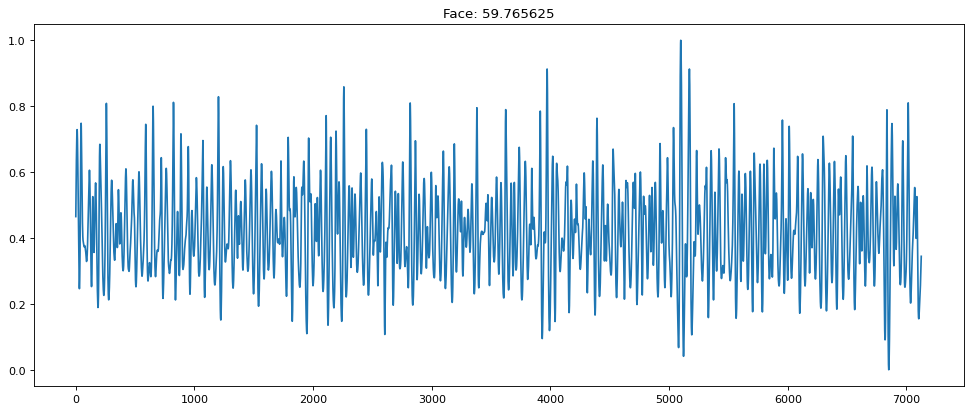

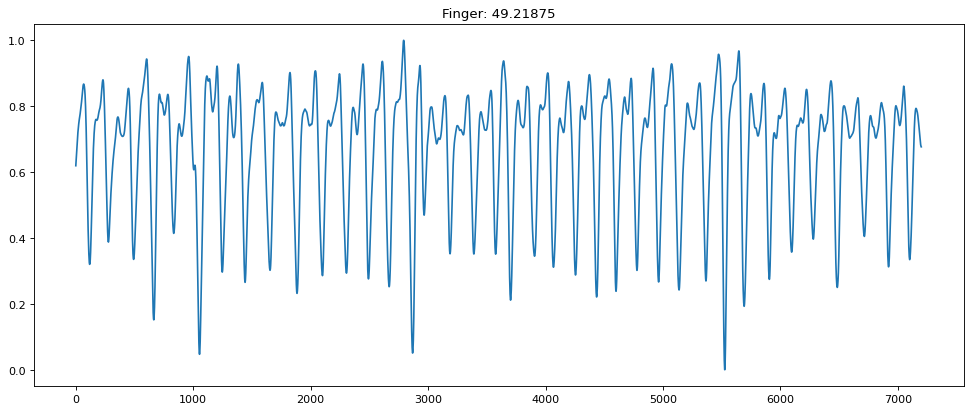

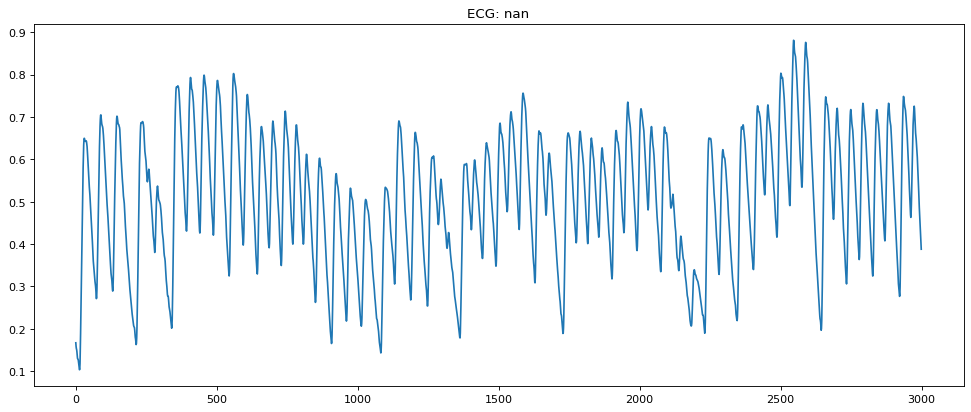

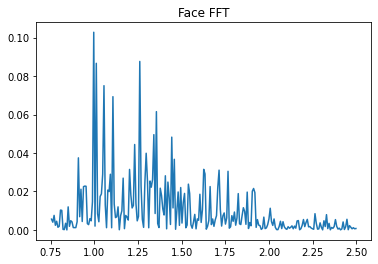

-----------------------


/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


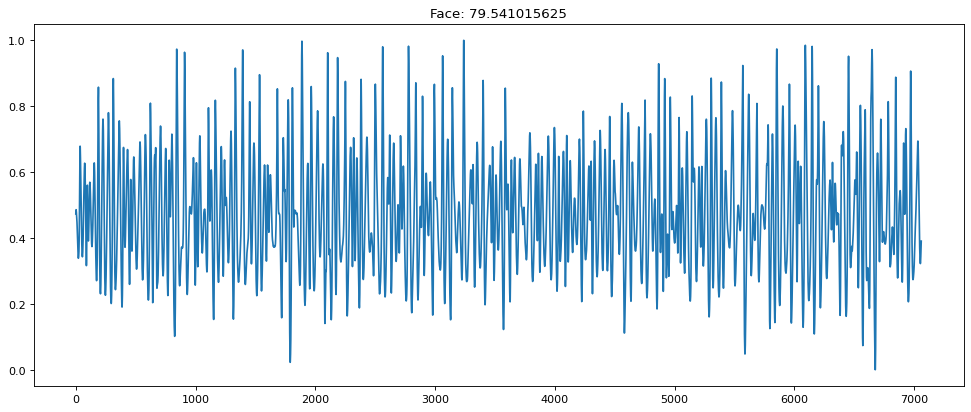

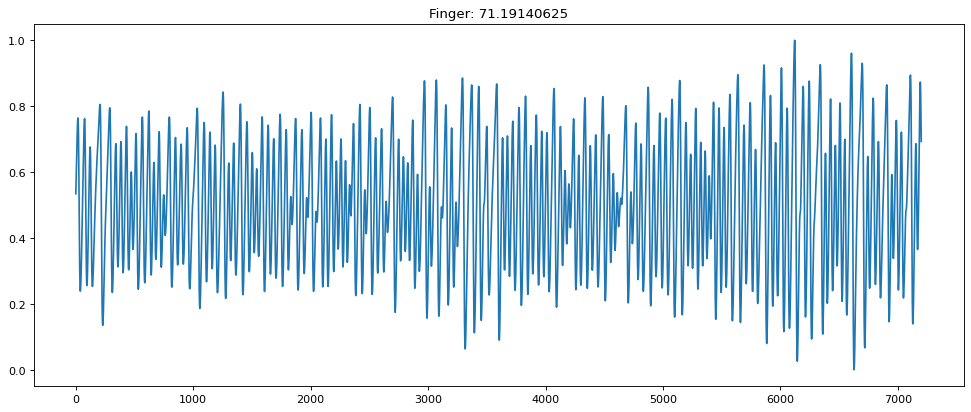

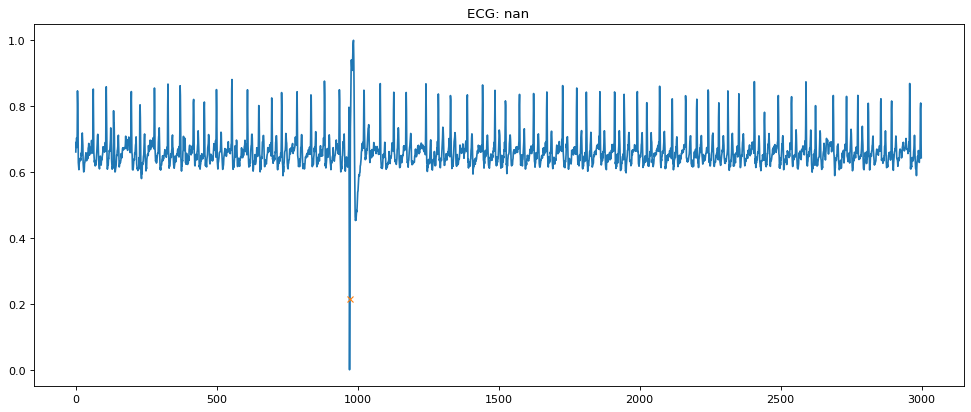

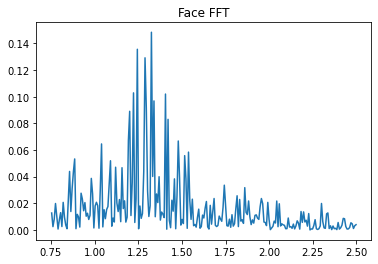

-----------------------


/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


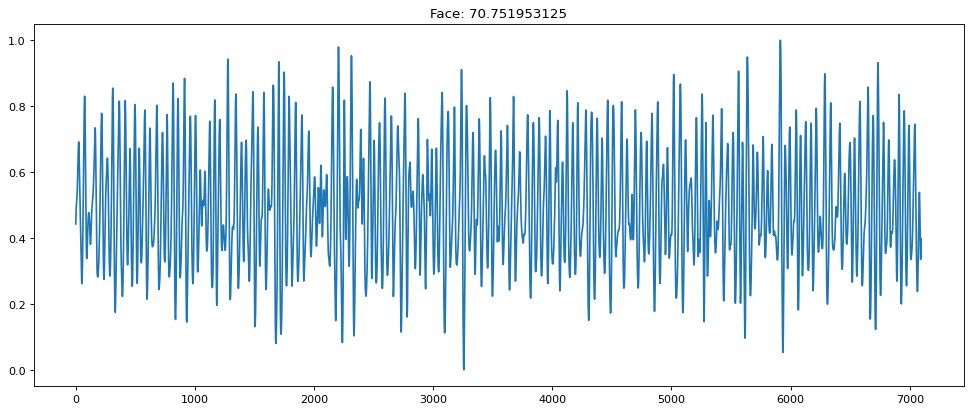

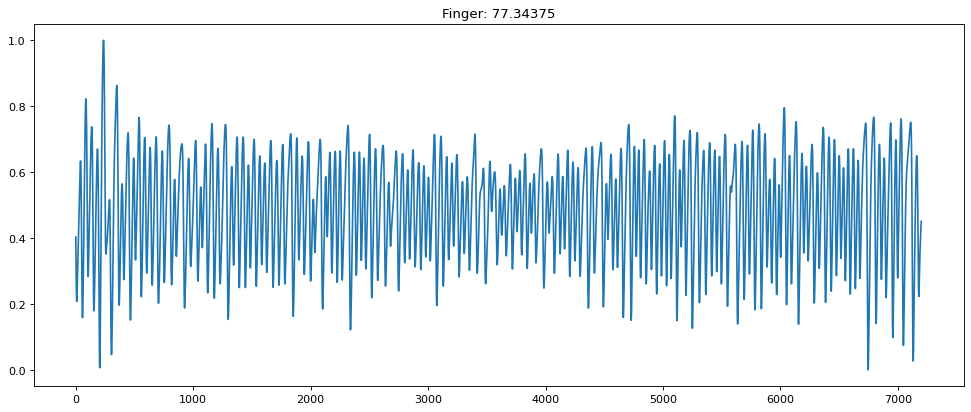

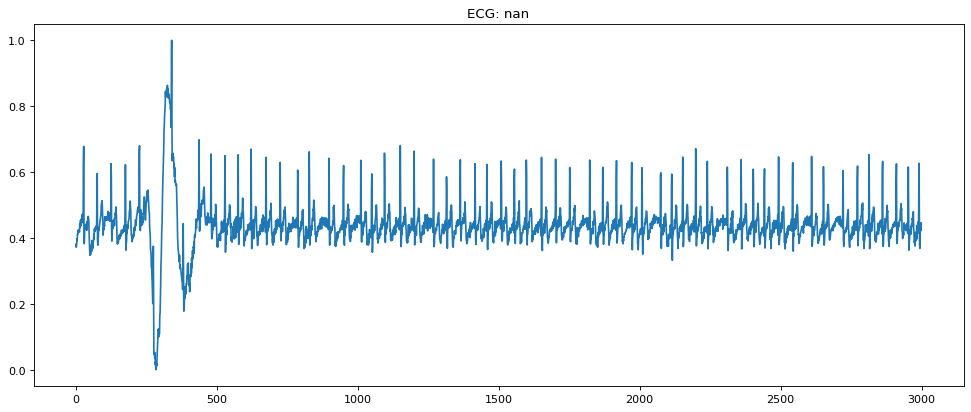

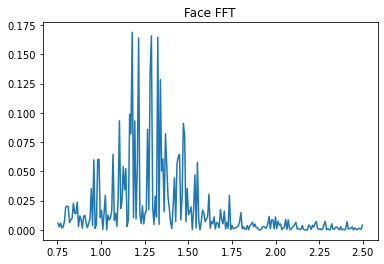

-----------------------


/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


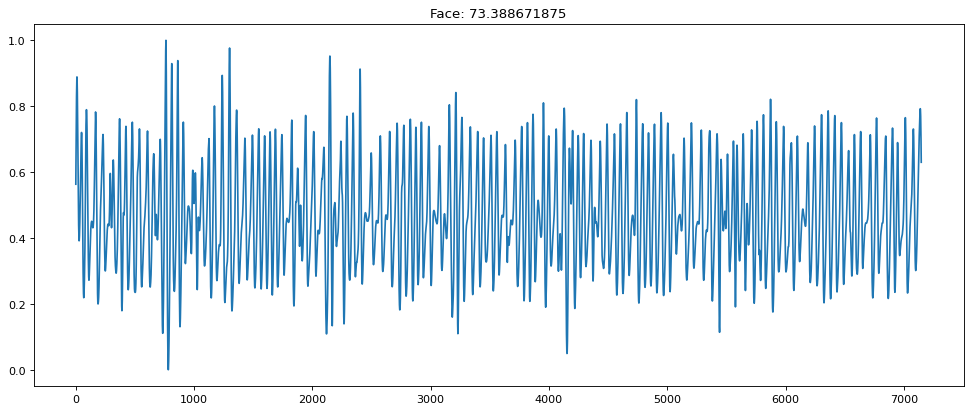

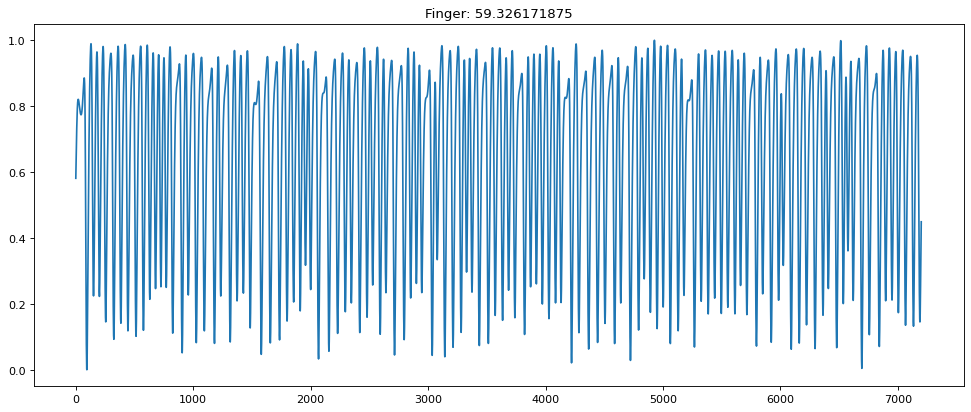

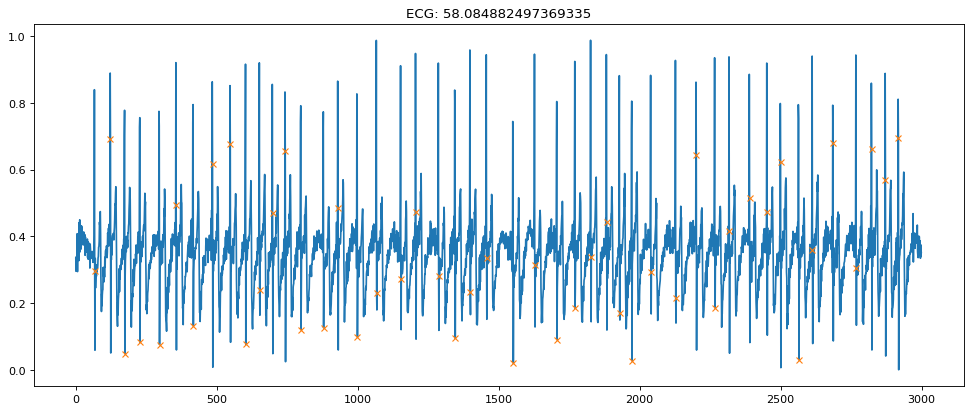

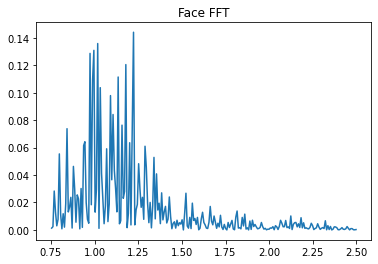

-----------------------


/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


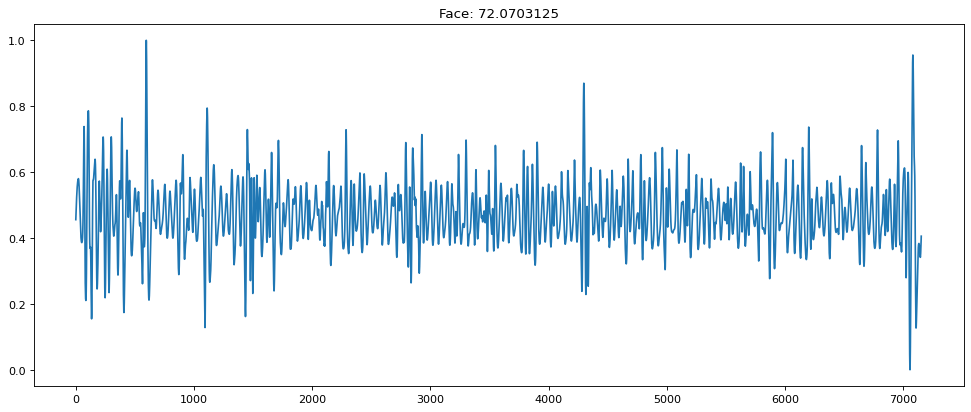

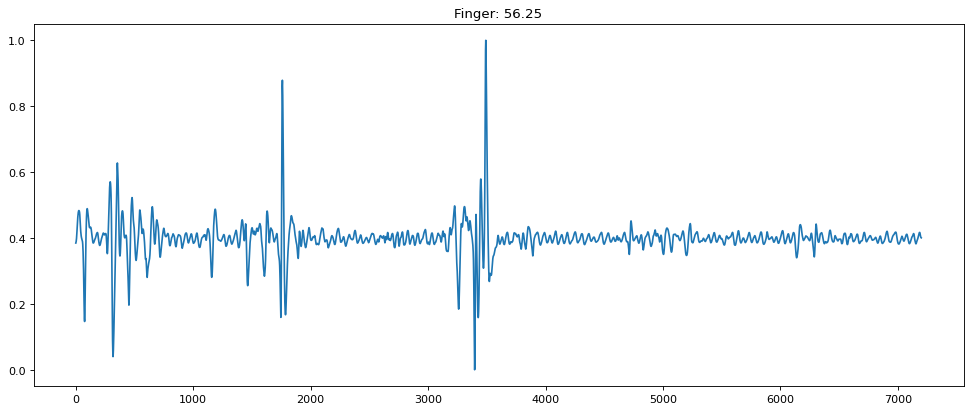

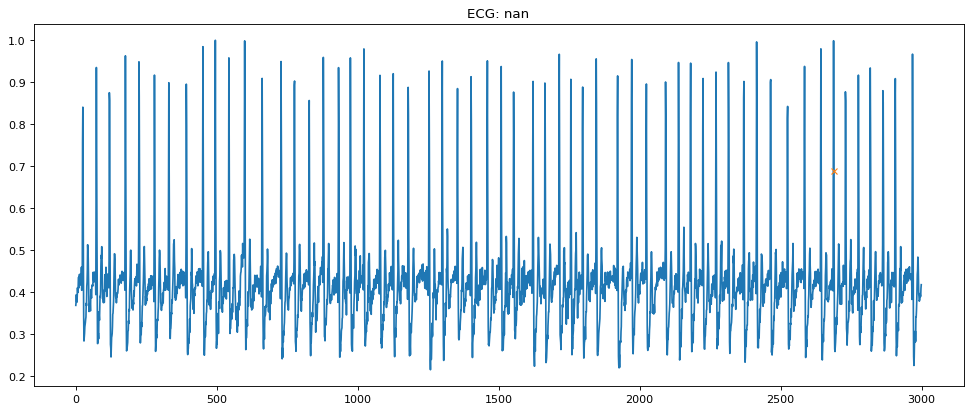

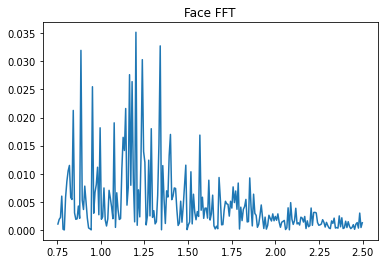

-----------------------


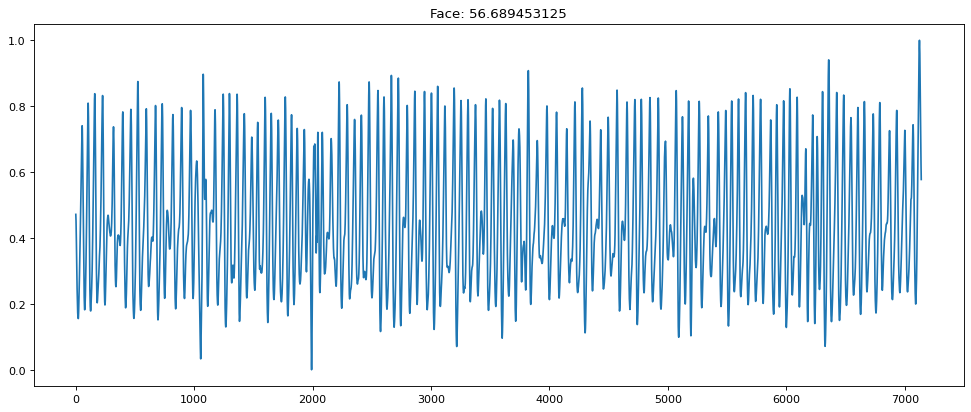

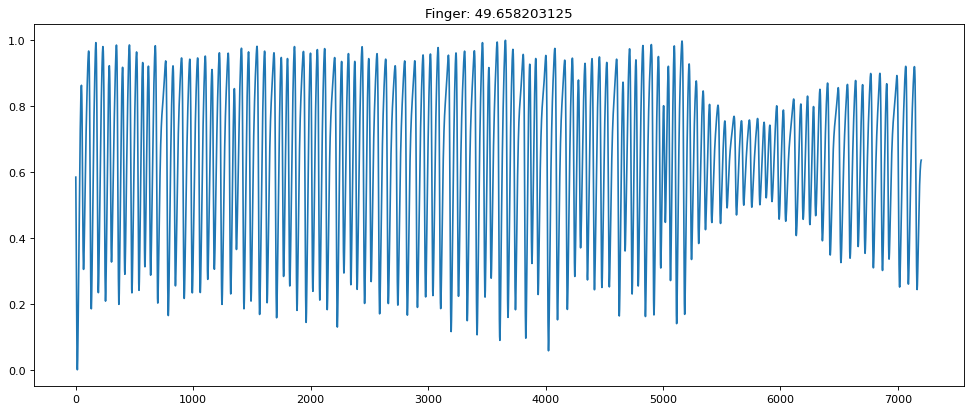

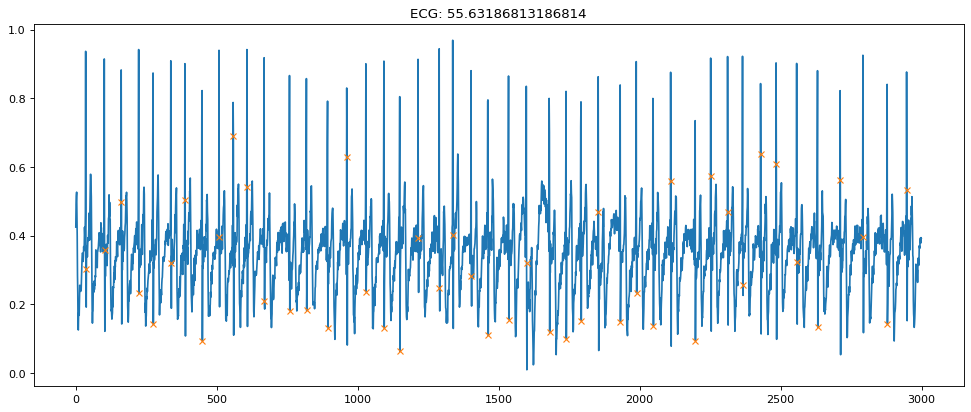

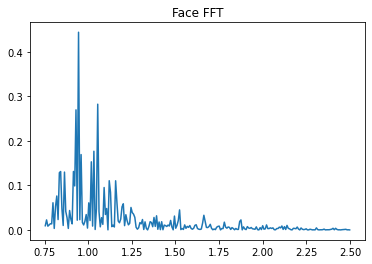

-----------------------


/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/xinliu/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
# all_mat_path = [all_mat_path[2]]
finger_hr_all = []
face_hr_all = []
window_size = 90
for idx, mat_path in enumerate(all_mat_path):
    mat = scipy.io.loadmat(mat_path)
    face_ppg = mat['ppg_face'][0]
    finger_ppg = 1 - mat['ppg'][0] 
    ecg = mat['ekg'][0]
#     finger_hr, face_hr, ecg_hr = calcuate_window_ibi(finger_ppg, face_ppg, ecg, window_size=window_size, fs=60)
    finger_hr, face_hr, ecg_hr = calcuate_video_hr_fft(finger_ppg, face_ppg, ecg, fs=60)    
    mae, rmse, mape = metrics_calculation(finger_hr, face_hr)
#     mae, rmse, mape = metrics_calculation(ecg_hr, finger_hr)
#     finger_hr_all.extend(finger_hr)
#     face_hr_all.extend(face_hr)
#     if mae > 10:
#         print('mat_path: ', os.path.basename(mat_path))
#         print('idx: ', idx)
#         print(f'MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')
#         print('---------------------------------------------')
# finger_hr_all, face_hr_all = np.array(finger_hr_all), np.array(face_hr_all)
# np.save(f'./finger_hr_all_ws_{str(window_size)}.npy', finger_hr_all)
# np.save(f'./face_hr_all_ws_{str(window_size)}.npy', face_hr_all)